In [2]:
import torch
from torch import nn
import pandas as pd
import numpy as np
from torchvision import datasets

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from datetime import datetime
from tqdm import tqdm
from colorama import Fore, Back

### Read the data

In [3]:
pd.options.display.max_columns = None

In [4]:
df_raw = pd.read_parquet('/Users/ruomingfang/Desktop/Ballbreaker/Spring 2022/research and thesis/PLACES data/25017_pc.pqt',engine='pyarrow')
df_raw

,fips,apn,apn2,owner,owntype,street,city,csd_id,tract_id,bg_id,zip_id,n,val_l,val_b,val_t,val_yr,ls_date,ls_price,ma_town_id,x,y,ha,slope,elev,travel,travel_weiss,abvg_biom,ghf,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,lake_nhd_id,river_frontage,river_ha_max,river_nhd_id,lake_dist,lake_nb_nhd_id,river_dist,river_nb_nhd_id,n_bld_fp,m2_bld_fp,lid,imp_id,apn_za,tax_id,owner_za,street_za,city_za,township,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,val_yr_za,tax_amt,tax_yr,ls_date_za,ls_price_za,zoning,n_bld_z,n_bld_zab,n_bld_zcode,bld_style,bld_found,bld_n_units,bld_n_stories,bld_n_rooms,bld_n_beds,bld_n_baths,bld_yr,bld_yr_eff,bld_yr_rem,bld_cond,bld_story_type,bld_code,bld_heat,bld_air,bld_sqft,bld_sqft_g,bld_sqft_b,x_za,y_za,p_prot,p_f,p_e,f_cid,f_name,f_year,f_orgname,f_orgtype,f_ha,f_p,e_cid,e_name,e_year,e_orgname,e_orgtype,e_gap,e_eas_deed,e_ha,e_p,p_prot_1984_200,p_prot_1984_1000,p_prot_1984_5000,p_prot_1985_200,p_prot_1985_1000,p_prot_1985_5000,p_prot_1986_200,p_prot_1986_1000,p_prot_1986_5000,p_prot_1987_200,p_prot_1987_1000,p_prot_1987_5000,p_prot_1988_200,p_prot_1988_1000,p_prot_1988_5000,p_prot_1989_200,p_prot_1989_1000,p_prot_1989_5000,p_prot_1990_200,p_prot_1990_1000,p_prot_1990_5000,p_prot_1991_200,p_prot_1991_1000,p_prot_1991_5000,p_prot_1992_200,p_prot_1992_1000,p_prot_1992_5000,p_prot_1993_200,p_prot_1993_1000,p_prot_1993_5000,p_prot_1994_200,p_prot_1994_1000,p_prot_1994_5000,p_prot_1995_200,p_prot_1995_1000,p_prot_1995_5000,p_prot_1996_200,p_prot_1996_1000,p_prot_1996_5000,p_prot_1997_200,p_prot_1997_1000,p_prot_1997_5000,p_prot_1998_200,p_prot_1998_1000,p_prot_1998_5000,p_prot_1999_200,p_prot_1999_1000,p_prot_1999_5000,p_prot_2000_200,p_prot_2000_1000,p_prot_2000_5000,p_prot_2001_200,p_prot_2001_1000,p_prot_2001_5000,p_prot_2002_200,p_prot_2002_1000,p_prot_2002_5000,p_prot_2003_200,p_prot_2003_1000,p_prot_2003_5000,p_prot_2004_200,p_prot_2004_1000,p_prot_2004_5000,p_prot_2005_200,p_prot_2005_1000,p_prot_2005_5000,p_prot_2006_200,p_prot_2006_1000,p_prot_2006_5000,p_prot_2007_200,p_prot_2007_1000,p_prot_2007_5000,p_prot_2008_200,p_prot_2008_1000,p_prot_2008_5000,p_prot_2009_200,p_prot_2009_1000,p_prot_2009_5000,p_prot_2010_200,p_prot_2010_1000,p_prot_2010_5000,p_prot_2011_200,p_prot_2011_1000,p_prot_2011_5000,p_prot_2012_200,p_prot_2012_1000,p_prot_2012_5000,p_prot_2013_200,p_prot_2013_1000,p_prot_2013_5000,p_prot_2014_200,p_prot_2014_1000,p_prot_2014_5000,p_prot_2015_200,p_prot_2015_1000,p_prot_2015_5000,p_prot_2016_200,p_prot_2016_1000,p_prot_2016_5000,p_prot_2017_200,p_prot_2017_1000,p_prot_2017_5000,p_prot_2018_200,p_prot_2018_1000,p_prot_2018_5000,n_prot_1990_f_1000,n_prot_1990_f_5000,n_prot_1990_e_1000,n_prot_1990_e_5000,n_prot_1995_f_1000,n_prot_1995_f_5000,n_prot_1995_e_1000,n_prot_1995_e_5000,n_prot_2000_f_1000,n_prot_2000_f_5000,n_prot_2000_e_1000,n_prot_2000_e_5000,n_prot_2005_f_1000,n_prot_2005_f_5000,n_prot_2005_e_1000,n_prot_2005_e_5000,n_prot_2010_f_1000,n_prot_2010_f_5000,n_prot_2010_e_1000,n_prot_2010_e_5000,n_prot_2015_f_1000,n_prot_2015_f_5000,n_prot_2015_e_1000,n_prot_2015_e_5000,ct_id,ct_year,ct_date,ct_protmech,ct_spending,ct_sp_pub,ct_sp_orgname,ct_sp_orgtype,ct_fips,ct_ha_from_ac,ct_p,ct_ha,fmv_d_2010,fmv_ud_2010,rd_dist_hwy,rd_dist_pvd,rd_dist_drt,p_bld_fp_200,p_bld_fp_1000,p_a_pontus_1988,p_a_pontus_2009,p_c_pontus_1988,p_c_pontus_2009,p_f_pontus_1988,p_f_pontus_2009,p_n_pontus_1988,p_n_pontus_2009,p_u_pontus_1988,p_u_pontus_2009,p_a_lcmap_1988,p_a_lcmap_2016,p_c_lcmap_1988,p_c_lcmap_2016,p_f_lcmap_1988,p_f_lcmap_2016,p_n_lcmap_1988,p_n_lcmap_2016,p_u_lcmap_1988,p_u_lcmap_2016,p_a_glance_2003,p_a_glance_2019,p_f_glance_2003,p_f_glance_2019,p_n_glance_2003,p_n_glance_2019,p_u_glance_2003,p_u_glance_2019,pop_dens_bg_2012-2016,hh_inc_med_bg_2012-2016,hh_inc_avg_bg_2012-2016,p_white_bg_2012-2016,p_black_bg_2012-2016,p_asian_bg_2012-2016,p_pacific_bg_201

In [5]:
lu_lookup = pd.read_csv('zillowlanduselookup.csv') #import the zillow land use dictionary
lu_lookup

,code,description,prefix,class
0,AG000,AGRICULTURAL GENERAL,AG,Agricultural
1,AG101,FARM (IRRIGATED OR DRY),AG,Agricultural
2,AG102,DAIRY FARM,AG,Agricultural
3,AG103,POULTRY FARM,AG,Agricultural
4,AG104,RANCH,AG,Agricultural
...,...,...,...,...
301,VL110,RECREATIONAL VACANT LAND,VL,Vacant Land
302,VL111,"WATER AREA (LAKE, RIVER, SHORE)",VL,Vacant Land
303,VL112,UNUSABLE LAND,VL,Vacant Land
304,VL113,"ABANDONED SITE, CONTAMINATED SITE",VL,Vacant Land


In [6]:
df_raw = df_raw.merge(lu_lookup[['code','description','class']],how='left',left_on='bld_code',right_on='code')

### Pre-processing steps

In [7]:
df_processed = df_raw.drop(columns=['fips','apn','apn2','csd_id','tract_id','bg_id','zip_id','ma_town_id', 
'lake_nhd_id','river_nhd_id','lake_nb_nhd_id','river_nb_nhd_id','lid','imp_id','apn_za','tax_id'])
df_processed

,owner,owntype,street,city,n,val_l,val_b,val_t,val_yr,ls_date,ls_price,x,y,ha,slope,elev,travel,travel_weiss,abvg_biom,ghf,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,owner_za,street_za,city_za,township,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,val_yr_za,tax_amt,tax_yr,ls_date_za,ls_price_za,zoning,n_bld_z,n_bld_zab,n_bld_zcode,bld_style,bld_found,bld_n_units,bld_n_stories,bld_n_rooms,bld_n_beds,bld_n_baths,bld_yr,bld_yr_eff,bld_yr_rem,bld_cond,bld_story_type,bld_code,bld_heat,bld_air,bld_sqft,bld_sqft_g,bld_sqft_b,x_za,y_za,p_prot,p_f,p_e,f_cid,f_name,f_year,f_orgname,f_orgtype,f_ha,f_p,e_cid,e_name,e_year,e_orgname,e_orgtype,e_gap,e_eas_deed,e_ha,e_p,p_prot_1984_200,p_prot_1984_1000,p_prot_1984_5000,p_prot_1985_200,p_prot_1985_1000,p_prot_1985_5000,p_prot_1986_200,p_prot_1986_1000,p_prot_1986_5000,p_prot_1987_200,p_prot_1987_1000,p_prot_1987_5000,p_prot_1988_200,p_prot_1988_1000,p_prot_1988_5000,p_prot_1989_200,p_prot_1989_1000,p_prot_1989_5000,p_prot_1990_200,p_prot_1990_1000,p_prot_1990_5000,p_prot_1991_200,p_prot_1991_1000,p_prot_1991_5000,p_prot_1992_200,p_prot_1992_1000,p_prot_1992_5000,p_prot_1993_200,p_prot_1993_1000,p_prot_1993_5000,p_prot_1994_200,p_prot_1994_1000,p_prot_1994_5000,p_prot_1995_200,p_prot_1995_1000,p_prot_1995_5000,p_prot_1996_200,p_prot_1996_1000,p_prot_1996_5000,p_prot_1997_200,p_prot_1997_1000,p_prot_1997_5000,p_prot_1998_200,p_prot_1998_1000,p_prot_1998_5000,p_prot_1999_200,p_prot_1999_1000,p_prot_1999_5000,p_prot_2000_200,p_prot_2000_1000,p_prot_2000_5000,p_prot_2001_200,p_prot_2001_1000,p_prot_2001_5000,p_prot_2002_200,p_prot_2002_1000,p_prot_2002_5000,p_prot_2003_200,p_prot_2003_1000,p_prot_2003_5000,p_prot_2004_200,p_prot_2004_1000,p_prot_2004_5000,p_prot_2005_200,p_prot_2005_1000,p_prot_2005_5000,p_prot_2006_200,p_prot_2006_1000,p_prot_2006_5000,p_prot_2007_200,p_prot_2007_1000,p_prot_2007_5000,p_prot_2008_200,p_prot_2008_1000,p_prot_2008_5000,p_prot_2009_200,p_prot_2009_1000,p_prot_2009_5000,p_prot_2010_200,p_prot_2010_1000,p_prot_2010_5000,p_prot_2011_200,p_prot_2011_1000,p_prot_2011_5000,p_prot_2012_200,p_prot_2012_1000,p_prot_2012_5000,p_prot_2013_200,p_prot_2013_1000,p_prot_2013_5000,p_prot_2014_200,p_prot_2014_1000,p_prot_2014_5000,p_prot_2015_200,p_prot_2015_1000,p_prot_2015_5000,p_prot_2016_200,p_prot_2016_1000,p_prot_2016_5000,p_prot_2017_200,p_prot_2017_1000,p_prot_2017_5000,p_prot_2018_200,p_prot_2018_1000,p_prot_2018_5000,n_prot_1990_f_1000,n_prot_1990_f_5000,n_prot_1990_e_1000,n_prot_1990_e_5000,n_prot_1995_f_1000,n_prot_1995_f_5000,n_prot_1995_e_1000,n_prot_1995_e_5000,n_prot_2000_f_1000,n_prot_2000_f_5000,n_prot_2000_e_1000,n_prot_2000_e_5000,n_prot_2005_f_1000,n_prot_2005_f_5000,n_prot_2005_e_1000,n_prot_2005_e_5000,n_prot_2010_f_1000,n_prot_2010_f_5000,n_prot_2010_e_1000,n_prot_2010_e_5000,n_prot_2015_f_1000,n_prot_2015_f_5000,n_prot_2015_e_1000,n_prot_2015_e_5000,ct_id,ct_year,ct_date,ct_protmech,ct_spending,ct_sp_pub,ct_sp_orgname,ct_sp_orgtype,ct_fips,ct_ha_from_ac,ct_p,ct_ha,fmv_d_2010,fmv_ud_2010,rd_dist_hwy,rd_dist_pvd,rd_dist_drt,p_bld_fp_200,p_bld_fp_1000,p_a_pontus_1988,p_a_pontus_2009,p_c_pontus_1988,p_c_pontus_2009,p_f_pontus_1988,p_f_pontus_2009,p_n_pontus_1988,p_n_pontus_2009,p_u_pontus_1988,p_u_pontus_2009,p_a_lcmap_1988,p_a_lcmap_2016,p_c_lcmap_1988,p_c_lcmap_2016,p_f_lcmap_1988,p_f_lcmap_2016,p_n_lcmap_1988,p_n_lcmap_2016,p_u_lcmap_1988,p_u_lcmap_2016,p_a_glance_2003,p_a_glance_2019,p_f_glance_2003,p_f_glance_2019,p_n_glance_2003,p_n_glance_2019,p_u_glance_2003,p_u_glance_2019,pop_dens_bg_2012-2016,hh_inc_med_bg_2012-2016,hh_inc_avg_bg_2012-2016,p_white_bg_2012-2016,p_black_bg_2012-2016,p_asian_bg_2012-2016,p_pacific_bg_2012-2016,p_other_bg_2012-2016,p_mixed_bg_2012-2016,p_hispanic_bg_2012-2016,p_ed_bsc_bg_2012-2016,p_ed_grad_bg_2012-2016,p_ed_phd_bg_2012-

In [8]:
df_processed = df_processed.drop(columns=['owner','owntype','street','city','val_yr','ls_date','x','y','ghf','owner_za','street_za','township','ls_date_za','zoning',
'bld_style','bld_found','bld_n_units','bld_n_stories','bld_n_rooms','bld_n_beds','bld_n_baths','bld_yr','bld_yr_eff','bld_yr_rem','bld_cond','bld_story_type','bld_heat','bld_air','bld_sqft','bld_sqft_g','bld_sqft_b',
'x_za','y_za'])
df_processed

,n,val_l,val_b,val_t,ls_price,ha,slope,elev,travel,travel_weiss,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,val_yr_za,tax_amt,tax_yr,ls_price_za,n_bld_z,n_bld_zab,n_bld_zcode,bld_code,p_prot,p_f,p_e,f_cid,f_name,f_year,f_orgname,f_orgtype,f_ha,f_p,e_cid,e_name,e_year,e_orgname,e_orgtype,e_gap,e_eas_deed,e_ha,e_p,p_prot_1984_200,p_prot_1984_1000,p_prot_1984_5000,p_prot_1985_200,p_prot_1985_1000,p_prot_1985_5000,p_prot_1986_200,p_prot_1986_1000,p_prot_1986_5000,p_prot_1987_200,p_prot_1987_1000,p_prot_1987_5000,p_prot_1988_200,p_prot_1988_1000,p_prot_1988_5000,p_prot_1989_200,p_prot_1989_1000,p_prot_1989_5000,p_prot_1990_200,p_prot_1990_1000,p_prot_1990_5000,p_prot_1991_200,p_prot_1991_1000,p_prot_1991_5000,p_prot_1992_200,p_prot_1992_1000,p_prot_1992_5000,p_prot_1993_200,p_prot_1993_1000,p_prot_1993_5000,p_prot_1994_200,p_prot_1994_1000,p_prot_1994_5000,p_prot_1995_200,p_prot_1995_1000,p_prot_1995_5000,p_prot_1996_200,p_prot_1996_1000,p_prot_1996_5000,p_prot_1997_200,p_prot_1997_1000,p_prot_1997_5000,p_prot_1998_200,p_prot_1998_1000,p_prot_1998_5000,p_prot_1999_200,p_prot_1999_1000,p_prot_1999_5000,p_prot_2000_200,p_prot_2000_1000,p_prot_2000_5000,p_prot_2001_200,p_prot_2001_1000,p_prot_2001_5000,p_prot_2002_200,p_prot_2002_1000,p_prot_2002_5000,p_prot_2003_200,p_prot_2003_1000,p_prot_2003_5000,p_prot_2004_200,p_prot_2004_1000,p_prot_2004_5000,p_prot_2005_200,p_prot_2005_1000,p_prot_2005_5000,p_prot_2006_200,p_prot_2006_1000,p_prot_2006_5000,p_prot_2007_200,p_prot_2007_1000,p_prot_2007_5000,p_prot_2008_200,p_prot_2008_1000,p_prot_2008_5000,p_prot_2009_200,p_prot_2009_1000,p_prot_2009_5000,p_prot_2010_200,p_prot_2010_1000,p_prot_2010_5000,p_prot_2011_200,p_prot_2011_1000,p_prot_2011_5000,p_prot_2012_200,p_prot_2012_1000,p_prot_2012_5000,p_prot_2013_200,p_prot_2013_1000,p_prot_2013_5000,p_prot_2014_200,p_prot_2014_1000,p_prot_2014_5000,p_prot_2015_200,p_prot_2015_1000,p_prot_2015_5000,p_prot_2016_200,p_prot_2016_1000,p_prot_2016_5000,p_prot_2017_200,p_prot_2017_1000,p_prot_2017_5000,p_prot_2018_200,p_prot_2018_1000,p_prot_2018_5000,n_prot_1990_f_1000,n_prot_1990_f_5000,n_prot_1990_e_1000,n_prot_1990_e_5000,n_prot_1995_f_1000,n_prot_1995_f_5000,n_prot_1995_e_1000,n_prot_1995_e_5000,n_prot_2000_f_1000,n_prot_2000_f_5000,n_prot_2000_e_1000,n_prot_2000_e_5000,n_prot_2005_f_1000,n_prot_2005_f_5000,n_prot_2005_e_1000,n_prot_2005_e_5000,n_prot_2010_f_1000,n_prot_2010_f_5000,n_prot_2010_e_1000,n_prot_2010_e_5000,n_prot_2015_f_1000,n_prot_2015_f_5000,n_prot_2015_e_1000,n_prot_2015_e_5000,ct_id,ct_year,ct_date,ct_protmech,ct_spending,ct_sp_pub,ct_sp_orgname,ct_sp_orgtype,ct_fips,ct_ha_from_ac,ct_p,ct_ha,fmv_d_2010,fmv_ud_2010,rd_dist_hwy,rd_dist_pvd,rd_dist_drt,p_bld_fp_200,p_bld_fp_1000,p_a_pontus_1988,p_a_pontus_2009,p_c_pontus_1988,p_c_pontus_2009,p_f_pontus_1988,p_f_pontus_2009,p_n_pontus_1988,p_n_pontus_2009,p_u_pontus_1988,p_u_pontus_2009,p_a_lcmap_1988,p_a_lcmap_2016,p_c_lcmap_1988,p_c_lcmap_2016,p_f_lcmap_1988,p_f_lcmap_2016,p_n_lcmap_1988,p_n_lcmap_2016,p_u_lcmap_1988,p_u_lcmap_2016,p_a_glance_2003,p_a_glance_2019,p_f_glance_2003,p_f_glance_2019,p_n_glance_2003,p_n_glance_2019,p_u_glance_2003,p_u_glance_2019,pop_dens_bg_2012-2016,hh_inc_med_bg_2012-2016,hh_inc_avg_bg_2012-2016,p_white_bg_2012-2016,p_black_bg_2012-2016,p_asian_bg_2012-2016,p_pacific_bg_2012-2016,p_other_bg_2012-2016,p_mixed_bg_2012-2016,p_hispanic_bg_2012-2016,p_ed_bsc_bg_2012-2016,p_ed_grad_bg_2012-2016,p_ed_phd_bg_2012-2016,code,description,class
0,1.0,263100.0,185000.0,448100.0,180900.0,0.065239,0.750000,21.232485,3.000000,0.000000,5.750000,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,71.250000,1591.000000,1.0,152.609001,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [9]:
df_processed = df_processed.drop(columns=['n'])
df_processed

,val_l,val_b,val_t,ls_price,ha,slope,elev,travel,travel_weiss,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,val_yr_za,tax_amt,tax_yr,ls_price_za,n_bld_z,n_bld_zab,n_bld_zcode,bld_code,p_prot,p_f,p_e,f_cid,f_name,f_year,f_orgname,f_orgtype,f_ha,f_p,e_cid,e_name,e_year,e_orgname,e_orgtype,e_gap,e_eas_deed,e_ha,e_p,p_prot_1984_200,p_prot_1984_1000,p_prot_1984_5000,p_prot_1985_200,p_prot_1985_1000,p_prot_1985_5000,p_prot_1986_200,p_prot_1986_1000,p_prot_1986_5000,p_prot_1987_200,p_prot_1987_1000,p_prot_1987_5000,p_prot_1988_200,p_prot_1988_1000,p_prot_1988_5000,p_prot_1989_200,p_prot_1989_1000,p_prot_1989_5000,p_prot_1990_200,p_prot_1990_1000,p_prot_1990_5000,p_prot_1991_200,p_prot_1991_1000,p_prot_1991_5000,p_prot_1992_200,p_prot_1992_1000,p_prot_1992_5000,p_prot_1993_200,p_prot_1993_1000,p_prot_1993_5000,p_prot_1994_200,p_prot_1994_1000,p_prot_1994_5000,p_prot_1995_200,p_prot_1995_1000,p_prot_1995_5000,p_prot_1996_200,p_prot_1996_1000,p_prot_1996_5000,p_prot_1997_200,p_prot_1997_1000,p_prot_1997_5000,p_prot_1998_200,p_prot_1998_1000,p_prot_1998_5000,p_prot_1999_200,p_prot_1999_1000,p_prot_1999_5000,p_prot_2000_200,p_prot_2000_1000,p_prot_2000_5000,p_prot_2001_200,p_prot_2001_1000,p_prot_2001_5000,p_prot_2002_200,p_prot_2002_1000,p_prot_2002_5000,p_prot_2003_200,p_prot_2003_1000,p_prot_2003_5000,p_prot_2004_200,p_prot_2004_1000,p_prot_2004_5000,p_prot_2005_200,p_prot_2005_1000,p_prot_2005_5000,p_prot_2006_200,p_prot_2006_1000,p_prot_2006_5000,p_prot_2007_200,p_prot_2007_1000,p_prot_2007_5000,p_prot_2008_200,p_prot_2008_1000,p_prot_2008_5000,p_prot_2009_200,p_prot_2009_1000,p_prot_2009_5000,p_prot_2010_200,p_prot_2010_1000,p_prot_2010_5000,p_prot_2011_200,p_prot_2011_1000,p_prot_2011_5000,p_prot_2012_200,p_prot_2012_1000,p_prot_2012_5000,p_prot_2013_200,p_prot_2013_1000,p_prot_2013_5000,p_prot_2014_200,p_prot_2014_1000,p_prot_2014_5000,p_prot_2015_200,p_prot_2015_1000,p_prot_2015_5000,p_prot_2016_200,p_prot_2016_1000,p_prot_2016_5000,p_prot_2017_200,p_prot_2017_1000,p_prot_2017_5000,p_prot_2018_200,p_prot_2018_1000,p_prot_2018_5000,n_prot_1990_f_1000,n_prot_1990_f_5000,n_prot_1990_e_1000,n_prot_1990_e_5000,n_prot_1995_f_1000,n_prot_1995_f_5000,n_prot_1995_e_1000,n_prot_1995_e_5000,n_prot_2000_f_1000,n_prot_2000_f_5000,n_prot_2000_e_1000,n_prot_2000_e_5000,n_prot_2005_f_1000,n_prot_2005_f_5000,n_prot_2005_e_1000,n_prot_2005_e_5000,n_prot_2010_f_1000,n_prot_2010_f_5000,n_prot_2010_e_1000,n_prot_2010_e_5000,n_prot_2015_f_1000,n_prot_2015_f_5000,n_prot_2015_e_1000,n_prot_2015_e_5000,ct_id,ct_year,ct_date,ct_protmech,ct_spending,ct_sp_pub,ct_sp_orgname,ct_sp_orgtype,ct_fips,ct_ha_from_ac,ct_p,ct_ha,fmv_d_2010,fmv_ud_2010,rd_dist_hwy,rd_dist_pvd,rd_dist_drt,p_bld_fp_200,p_bld_fp_1000,p_a_pontus_1988,p_a_pontus_2009,p_c_pontus_1988,p_c_pontus_2009,p_f_pontus_1988,p_f_pontus_2009,p_n_pontus_1988,p_n_pontus_2009,p_u_pontus_1988,p_u_pontus_2009,p_a_lcmap_1988,p_a_lcmap_2016,p_c_lcmap_1988,p_c_lcmap_2016,p_f_lcmap_1988,p_f_lcmap_2016,p_n_lcmap_1988,p_n_lcmap_2016,p_u_lcmap_1988,p_u_lcmap_2016,p_a_glance_2003,p_a_glance_2019,p_f_glance_2003,p_f_glance_2019,p_n_glance_2003,p_n_glance_2019,p_u_glance_2003,p_u_glance_2019,pop_dens_bg_2012-2016,hh_inc_med_bg_2012-2016,hh_inc_avg_bg_2012-2016,p_white_bg_2012-2016,p_black_bg_2012-2016,p_asian_bg_2012-2016,p_pacific_bg_2012-2016,p_other_bg_2012-2016,p_mixed_bg_2012-2016,p_hispanic_bg_2012-2016,p_ed_bsc_bg_2012-2016,p_ed_grad_bg_2012-2016,p_ed_phd_bg_2012-2016,code,description,class
0,263100.0,185000.0,448100.0,180900.0,0.065239,0.750000,21.232485,3.000000,0.000000,5.750000,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,71.250000,1591.000000,1.0,152.609001,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [11]:
list_of_attr = [
 'ha',
 'slope',
 'elev',
 'travel',
 'abvg_biom',
 'p_water',
 'p_dev_open',
 'p_dev_low',
 'p_dev_medium',
 'p_dev_high',
 'p_barren',
 'p_forest_d',
 'p_forest_e',
 'p_forest_m',
 'p_shrub',
 'p_grassland',
 'p_pasture',
 'p_crops',
 'p_wetland_w',
 'p_wetland_e',
 'lake_frontage',
 'lake_ha_max',
 'river_frontage',
 'river_ha_max',
 'lake_dist',
 'river_dist',
 'n_bld_fp',
 'm2_bld_fp',
 'city_za',
 'lot_ac',
 'lot_sqft',
 'val_l_za',
 'val_b_za',
 'val_t_za',
 'pop_dens_bg_2012-2016',
 'hh_inc_avg_bg_2012-2016',
 'class']
df_sel = df_processed[list_of_attr]
df_sel

,ha,slope,elev,travel,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,pop_dens_bg_2012-2016,hh_inc_avg_bg_2012-2016,class
0,0.065239,0.750000,21.232485,3.000000,5.750000,0.0,0.0,50.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,71.250000,1591.000000,1.0,152.609001,None,NaN,NaN,NaN,NaN,NaN,2600.380896,106261.647727,NaN
1,0.246093,2.700000,83.386344,17.000000,59.000000,0.0,10.0,80.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,232.600000,2603.500000,1.0,157.370433,MARLBOROUGH,0.597,25985.0,133800.0,210800.0,344600.0,469.298752,99307.992565,Residential
2,52.231484,6.620035,59.898636,4.848446,141.069085,0.0,9.4,0.3,0.7,0.0,0.0,78.5,9.5,1.4,0.0,0.0,0.0,0.0,0.3,0.0,NaN,NaN,NaN,NaN,2001.291019,1339.629965,0.0,0.000000,BILLERICA,135.000,5880600.0,5624800.0,NaN,5624800.0,259.219640,103558.474576,Governmental
3,0.050843,3.000000,42.424817,6.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1820.000000,5172.000000,1.0,105.727551,STONEHAM,0.120,5216.0,217000.0,246500.0,463500.0,2681.131857,75519.012346,Residential
4,0.039938,0.000000,11.743778,4.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,977.000000,314.500000,1.0,76.982675,MALDEN,0.099,4308.0,192200.0,169200.0,361400.0,1303.712295,68911.210762,Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421232,2.881665,1.710938,90.958719,10.000000,31.898438,0.0,4.7,18.0,70.3,0.0,0.0,6.2,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.0,NaN,NaN,NaN,NaN,2488.093750,2712.546875,0.0,0.000000,None,NaN,NaN,NaN,NaN,NaN,167.054904,157437.485971,NaN
421233,3.425223,4.039735,51.156790,6.887417,54.456954,0.0,29.8,27.8,11.9,21.9,0.0,1.3,0.7,0.0,0.0,0.0,0.0,0.0,2.0,4.6,NaN,NaN,140.0,256.990321,872.834437,114.417219,0.0,0.000000,None,NaN,NaN,NaN,NaN,NaN,184.937061,136661.640798,NaN
421234,1.490042,3.666667,32.675498,8.257576,18.909091,0.0,3.0,7.6,69.7,18.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,NaN,NaN,NaN,NaN,769.015152,4099.166667,0.0,0.000000,None,NaN,NaN,NaN,NaN,NaN,502.638346,111369.121813,NaN
421235,6.022729,0.092664,42.753435,13.169884,34.135135,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.1,96.9,72.0,10.1,NaN,NaN,1.625483,3086.903475,0.0,0.000000,None,NaN,NaN,NaN,NaN,NaN,647.423794,104125.032092,NaN


In [12]:
df_sel = df_sel[df_sel['val_l_za'].notna()]
df_sel = df_sel[df_sel['city_za'].notna()]
df_sel = df_sel[df_sel['lot_ac'].notna()]
df_sel = df_sel[df_sel['lot_sqft'].notna()]

df_sel

,ha,slope,elev,travel,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,pop_dens_bg_2012-2016,hh_inc_avg_bg_2012-2016,class
1,0.246093,2.700000,83.386344,17.000000,59.000000,0.0,10.0,80.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,232.600000,2603.500000,1.0,157.370433,MARLBOROUGH,0.597,25985.0,133800.0,210800.0,344600.0,469.298752,99307.992565,Residential
2,52.231484,6.620035,59.898636,4.848446,141.069085,0.0,9.4,0.3,0.7,0.0,0.0,78.5,9.5,1.4,0.0,0.0,0.0,0.0,0.3,0.0,NaN,NaN,NaN,NaN,2001.291019,1339.629965,0.0,0.000000,BILLERICA,135.000,5880600.0,5624800.0,NaN,5624800.0,259.219640,103558.474576,Governmental
3,0.050843,3.000000,42.424817,6.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1820.000000,5172.000000,1.0,105.727551,STONEHAM,0.120,5216.0,217000.0,246500.0,463500.0,2681.131857,75519.012346,Residential
4,0.039938,0.000000,11.743778,4.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,977.000000,314.500000,1.0,76.982675,MALDEN,0.099,4308.0,192200.0,169200.0,361400.0,1303.712295,68911.210762,Residential
5,0.015205,1.000000,66.851277,10.000000,37.000000,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1418.000000,2567.000000,0.0,0.000000,NATICK,0.038,1655.0,2500.0,NaN,2500.0,899.340221,105609.719626,Vacant Land
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420023,0.571101,0.000000,10.014514,0.000000,2.640000,0.0,0.0,0.0,32.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,945.160000,296.040000,1.0,3653.738461,CAMBRIDGE,0.580,25273.0,2399900.0,4016400.0,6416300.0,3351.347592,69533.333333,Commercial Retail
420102,0.035679,1.500000,28.666706,3.000000,15.500000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1233.500000,3238.500000,1.0,140.623813,MELROSE,0.087,3808.0,231000.0,137900.0,368900.0,3776.190277,118028.928571,Residential Income - Multi-Family
420286,0.561729,1.000000,14.126436,3.000000,0.720000,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1282.640000,114.960000,0.0,0.000000,CAMBRIDGE,1.370,59669.0,950000.0,2291900.0,3241900.0,1512.031719,98853.051643,Residential
420385,0.608533,1.000000,10.915701,5.000000,0.740741,0.0,0.0,0.0,14.8,85.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2552.296296,112.666667,1.0,4509.751042,CAMBRIDGE,1.420,61780.0,26827300.0,74133400.0,100960704.0,2622.818150,162866.500000,Commercial Office


In [16]:
df_sel['val_l_sqft'] = df_sel['val_l_za'] / df_sel['lot_sqft']
df_sel

/var/folders/1f/598yjlks31q8_87y6wgw3xpr0000gn/T/ipykernel_84998/1201959638.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel['val_l_sqft'] = df_sel['val_l_za'] / df_sel['lot_sqft']


,ha,slope,elev,travel,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,lot_ac,lot_sqft,val_l_za,val_b_za,val_t_za,pop_dens_bg_2012-2016,hh_inc_avg_bg_2012-2016,class,val_l_sqft
1,0.246093,2.700000,83.386344,17.000000,59.000000,0.0,10.0,80.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,232.600000,2603.500000,1.0,157.370433,MARLBOROUGH,0.597,25985.0,133800.0,210800.0,344600.0,469.298752,99307.992565,Residential,5.149125
2,52.231484,6.620035,59.898636,4.848446,141.069085,0.0,9.4,0.3,0.7,0.0,0.0,78.5,9.5,1.4,0.0,0.0,0.0,0.0,0.3,0.0,NaN,NaN,NaN,NaN,2001.291019,1339.629965,0.0,0.000000,BILLERICA,135.000,5880600.0,5624800.0,NaN,5624800.0,259.219640,103558.474576,Governmental,0.956501
3,0.050843,3.000000,42.424817,6.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1820.000000,5172.000000,1.0,105.727551,STONEHAM,0.120,5216.0,217000.0,246500.0,463500.0,2681.131857,75519.012346,Residential,41.602760
4,0.039938,0.000000,11.743778,4.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,977.000000,314.500000,1.0,76.982675,MALDEN,0.099,4308.0,192200.0,169200.0,361400.0,1303.712295,68911.210762,Residential,44.614670
5,0.015205,1.000000,66.851277,10.000000,37.000000,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1418.000000,2567.000000,0.0,0.000000,NATICK,0.038,1655.0,2500.0,NaN,2500.0,899.340221,105609.719626,Vacant Land,1.510574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420023,0.571101,0.000000,10.014514,0.000000,2.640000,0.0,0.0,0.0,32.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,945.160000,296.040000,1.0,3653.738461,CAMBRIDGE,0.580,25273.0,2399900.0,4016400.0,6416300.0,3351.347592,69533.333333,Commercial Retail,94.959045
420102,0.035679,1.500000,28.666706,3.000000,15.500000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1233.500000,3238.500000,1.0,140.623813,MELROSE,0.087,3808.0,231000.0,137900.0,368900.0,3776.190277,118028.928571,Residential Income - Multi-Family,60.661766
420286,0.561729,1.000000,14.126436,3.000000,0.720000,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1282.640000,114.960000,0.0,0.000000,CAMBRIDGE,1.370,59669.0,950000.0,2291900.0,3241900.0,1512.031719,98853.051643,Residential,15.921165
420385,0.608533,1.000000,10.915701,5.000000,0.740741,0.0,0.0,0.0,14.8,85.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2552.296296,112.666667,1.0,4509.751042,CAMBRIDGE,1.420,61780.0,26827300.0,74133400.0,100960704.0,2622.818150,162866.500000,Commercial Office,434.239227


In [17]:
data_final = df_sel.drop(columns=['val_l_za','val_b_za','val_t_za','lot_ac','lot_sqft','ha'])
data_final

,slope,elev,travel,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,city_za,pop_dens_bg_2012-2016,hh_inc_avg_bg_2012-2016,class,val_l_sqft
1,2.700000,83.386344,17.000000,59.000000,0.0,10.0,80.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,232.600000,2603.500000,1.0,157.370433,MARLBOROUGH,469.298752,99307.992565,Residential,5.149125
2,6.620035,59.898636,4.848446,141.069085,0.0,9.4,0.3,0.7,0.0,0.0,78.5,9.5,1.4,0.0,0.0,0.0,0.0,0.3,0.0,NaN,NaN,NaN,NaN,2001.291019,1339.629965,0.0,0.000000,BILLERICA,259.219640,103558.474576,Governmental,0.956501
3,3.000000,42.424817,6.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1820.000000,5172.000000,1.0,105.727551,STONEHAM,2681.131857,75519.012346,Residential,41.602760
4,0.000000,11.743778,4.000000,1.000000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,977.000000,314.500000,1.0,76.982675,MALDEN,1303.712295,68911.210762,Residential,44.614670
5,1.000000,66.851277,10.000000,37.000000,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1418.000000,2567.000000,0.0,0.000000,NATICK,899.340221,105609.719626,Vacant Land,1.510574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420023,0.000000,10.014514,0.000000,2.640000,0.0,0.0,0.0,32.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,945.160000,296.040000,1.0,3653.738461,CAMBRIDGE,3351.347592,69533.333333,Commercial Retail,94.959045
420102,1.500000,28.666706,3.000000,15.500000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1233.500000,3238.500000,1.0,140.623813,MELROSE,3776.190277,118028.928571,Residential Income - Multi-Family,60.661766
420286,1.000000,14.126436,3.000000,0.720000,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,1282.640000,114.960000,0.0,0.000000,CAMBRIDGE,1512.031719,98853.051643,Residential,15.921165
420385,1.000000,10.915701,5.000000,0.740741,0.0,0.0,0.0,14.8,85.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,2552.296296,112.666667,1.0,4509.751042,CAMBRIDGE,2622.818150,162866.500000,Commercial Office,434.239227


In [18]:
all_features = data_final.iloc[:,:-1]

In [19]:
all_outputs = data_final.iloc[:,-1]

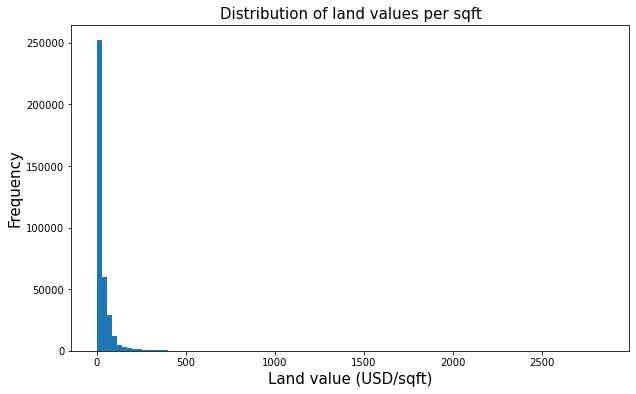

In [123]:
# plot a histogram of land values

plt.figure(figsize=(10,6))
plt.hist(all_outputs, bins=100)
plt.title('Distribution of land values per sqft',fontsize = 15)
plt.xlabel('Land value (USD/sqft)', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

In [23]:
# Pre-processing

# standardize the numerical features
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))

# replace the na values with zeroes
all_features[numeric_features] = all_features[numeric_features].fillna(0)

# one-hot encoding of categorical features
all_features = pd.get_dummies(all_features, dummy_na=True)

print(f'Data Shape: {all_features.shape}')

Data Shape: (370159, 121)


In [24]:
all_features

,slope,elev,travel,abvg_biom,p_water,p_dev_open,p_dev_low,p_dev_medium,p_dev_high,p_barren,p_forest_d,p_forest_e,p_forest_m,p_shrub,p_grassland,p_pasture,p_crops,p_wetland_w,p_wetland_e,lake_frontage,lake_ha_max,river_frontage,river_ha_max,lake_dist,river_dist,n_bld_fp,m2_bld_fp,pop_dens_bg_2012-2016,hh_inc_avg_bg_2012-2016,city_za_ACTON,city_za_ARLINGTON,city_za_ASHBY,city_za_ASHLAND,city_za_AUBURNDALE,city_za_AYER,city_za_BEDFORD,city_za_BELMONT,city_za_BILLERICA,city_za_BOSTON,city_za_BOXBORO,city_za_BURLINGTON,city_za_CAMBRIDGE,city_za_CARLISLE,city_za_CHARLESTOWN,city_za_CHELMSFORD,city_za_CHESTNUT HILL,city_za_CONCORD,city_za_DORCHESTER,city_za_DOVER,city_za_DRACUT,city_za_DUNSTABLE,city_za_EAST CAMBRIDGE,city_za_EVERETT,city_za_FRAMINGHAM,city_za_GROTON,city_za_HARVARD,city_za_HOLLISTON,city_za_HOPKINTON,city_za_HUDSON,city_za_LEXINGTON,city_za_LINCOLN,city_za_LITTLETON,city_za_LOWELL,city_za_LUNENBURG,city_za_LYNNFIELD,city_za_MALDEN,city_za_MARLBOROUGH,city_za_MAYNARD,city_za_MEDFORD,city_za_MELROSE,city_za_MILLIS,city_za_NATICK,city_za_NEWTON,city_za_NEWTON HIGHLANDS,city_za_NORTH BILLERICA,city_za_NORTH CAMBRIDGE,city_za_NORTH CHELMSFORD,city_za_NORTH READING,city_za_PEPPERELL,city_za_READING,city_za_ROXBURY,city_za_ROXBURY CROSSING,city_za_SHERBORN,city_za_SHIRLEY,city_za_SOMERVILLE,city_za_SOUTH BOSTON,city_za_STONEHAM,city_za_STOW,city_za_SUDBURY,city_za_TEWKSBURY,city_za_TOWNSEND,city_za_TYNGSBORO,city_za_WABAN,city_za_WAKEFIELD,city_za_WALTHAM,city_za_WATERTOWN,city_za_WAYLAND,city_za_WEST NEWTON,city_za_WEST TOWNSEND,city_za_WESTBOROUGH,city_za_WESTFORD,city_za_WESTON,city_za_WILMINGTON,city_za_WINCHESTER,city_za_WOBURN,city_za_nan,class_Agricultural,class_Commercial Office,class_Commercial Retail,class_Communication,class_Exempt & Institutional,class_Governmental,class_Industrial,class_Industrial-Heavy,class_Miscellaneous,class_Recreational,class_Residential,class_Residential Income - Multi-Family,class_Transportation,class_Vacant Land,class_nan
1,-0.099605,0.863057,0.291644,0.152793,-0.073823,-0.127245,1.862688,-0.663792,-0.396668,-0.036561,-0.379981,-0.234899,-0.093135,-0.073618,-0.053449,-0.125402,-0.029905,-0.229165,-0.083382,0.0,0.0,0.0,0.0,-1.268034,0.133078,0.012837,-0.070844,-0.582994,-0.548536,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,1.425215,0.145093,-0.375268,1.803866,-0.073823,-0.152219,-0.741129,-0.899708,-0.396668,-0.036561,3.291759,0.493353,0.278358,-0.073618,-0.053449,-0.125402,-0.029905,-0.203872,-0.083382,0.0,0.0,0.0,0.0,0.278699,-0.539455,-0.900760,-0.259666,-0.658210,-0.471887,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0.017090,-0.389041,-0.312068,-1.014056,-0.073823,-0.543476,-0.750930,1.619264,-0.396668,-0.036561,-0.379981,-0.234899,-0.093135,-0.073618,-0.053449,-0.125402,-0.029905,-0.229165,-0.083382,0.0,0.0,0.0,0.0,0.120159,1.499834,0.012837,-0.132808,0.208914,-0.977517,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-1.149854,-1.326888,-0.421833,-1.014056,-0.073823,-0.543476,-0.750930,1.619264,-0.396668,-0.036561,-0.379981,-0.234899,-0.093135,-0.073618,-0.053449,-0.125402,-0.029905,-0.229165,-0.083382,0.0,0.0,0.0,0.0,-0.617051,-1.084949,0.012837,-0.167298,-0.284247,-1.096675,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,-0.760873,0.357619,-0.092536,-0.289805,-0.073823,3.618830,-0.750930,-0.917465,-0.396668,-0.036561,-0.379981,-0.234899,-0.093135,-0.073618,-0.053449,-0.125402,-0.029905,-0.229165,-0.083382,0.0,0.0,0.0,0.0,-0.231393

### Training and testing

In [110]:
# split the data
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(all_features, all_outputs, test_size=0.2, random_state=42)

In [111]:
# convert the x into tensor

x_train = torch.tensor(x_train.values, dtype=torch.float)
x_val = torch.tensor(x_val.values, dtype=torch.float)

In [112]:
# convert the y into tensor; unsqueeze function is used to make x and y have same dimension for MSELoss

y_train = torch.tensor(y_train.values, dtype=torch.float)
y_train = y_train.unsqueeze(1)

y_val = torch.tensor(y_val.values,dtype=torch.float)
y_val = y_val.unsqueeze(1)

In [113]:
print(f'training data: {x_train.shape}')
print(f'validation data: {x_val.shape}')

training data: torch.Size([296127, 121])
validation data: torch.Size([74032, 121])


In [114]:
# Define the pytorch dataset

from torch.utils.data import Dataset, DataLoader

class RegressionDataset(Dataset):
    def __init__(self,x_data,y_data):
        self.x= x_data  
        self.y= y_data 
        self.len=self.x.shape[0]

    def __getitem__(self,index):      
        return self.x[index], self.y[index]

    def __len__(self):
        return self.len

train_dataset = RegressionDataset(x_train,y_train)
val_dataset = RegressionDataset(x_val,y_val)

# load the dataset
train_iter = DataLoader(dataset=train_dataset, batch_size=64)
val_iter = DataLoader(dataset=val_dataset, batch_size=64)


In [115]:
# Define the neural network structure

device = "cpu"

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

class PXRegressNN(nn.Module):
    def __init__(self):
        super(PXRegressNN,self).__init__()
        # self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(121,256),
            nn.ReLU(),
            nn.Linear(256,256),
            nn.ReLU(),
            nn.Linear(256,1)
        )
        self.apply(init_weights)

    def forward(self,x):
        # x = self.flatten(x)
        y_pred = self.linear_relu_stack(x)
        return y_pred
    
model = PXRegressNN().to(device)
print(model)

PXRegressNN(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=121, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=1, bias=True)
  )
)


In [116]:
learning_rate = 1e-4

loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [117]:
from sklearn.metrics import mean_squared_error

# RMSE as the evaluation criterion
def custom_score(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    return rmse

In [118]:
# utility function to plot true vs predicted value

def plot_true_pred(true_value,predicted_value):
    plt.figure(figsize=(10,10))
    plt.scatter(true_value, predicted_value, c='crimson')
    plt.yscale('log')
    plt.xscale('log')

    p1 = max(max(predicted_value), max(true_value))
    p2 = min(min(predicted_value), min(true_value))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.title('True vs. Predicted values',fontsize = 15)
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()    

In [119]:
# Training and test routines

def train_loop(dataloader, model, loss_fn, optimizer):
    y_true = []
    y_pred = []
    mean_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        mean_loss.append(loss.item())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_pred.extend(pred.detach().cpu().squeeze().numpy().tolist())
        y_true.extend(y.detach().cpu().squeeze().numpy().tolist())

    rmse = custom_score(y_true, y_pred)
    mean_loss = np.mean(mean_loss)
    
    rmse = np.round(rmse, 4)
    mean_loss = np.round(mean_loss, 4)
    return batch, mean_loss, rmse
    # return y_true, y_pred

def test_loop(dataloader, model, loss_fn):
    y_true = []
    y_pred = []    
    mean_loss = []
    size = len(dataloader.dataset)

    with torch.no_grad():
        for (X, y) in dataloader:
            pred = model(X)
            mean_loss.append(loss_fn(pred,y).item())
            
            y_pred.extend(pred.detach().cpu().squeeze().numpy().tolist())
            y_true.extend(y.detach().cpu().squeeze().numpy().tolist())

    rmse = custom_score(y_true, y_pred)
    mean_loss = np.mean(mean_loss)

    rmse = np.round(rmse, 4)
    mean_loss = np.round(mean_loss, 4)
    
    return mean_loss, rmse, y_true,y_pred
  

2022-05-09 00:13:17.324249 开始训练...


  0%|          | 0/200 [00:06<?, ?it/s]

Epoch: 0 Train loss: 921.5657 Val loss: 714.9691 Train score: 30.3573 Val score 26.7412


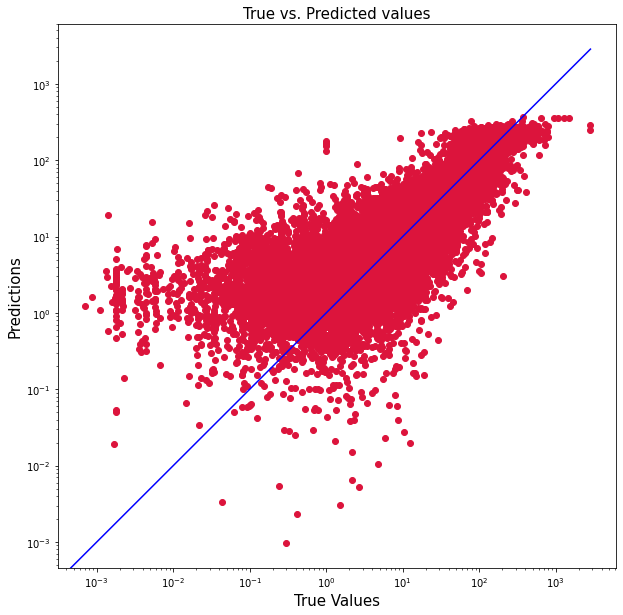

  5%|▌         | 10/200 [01:19<22:41,  7.17s/it]

Epoch: 10 Train loss: 547.6165 Val loss: 528.6207 Train score: 23.4012 Val score 22.9933


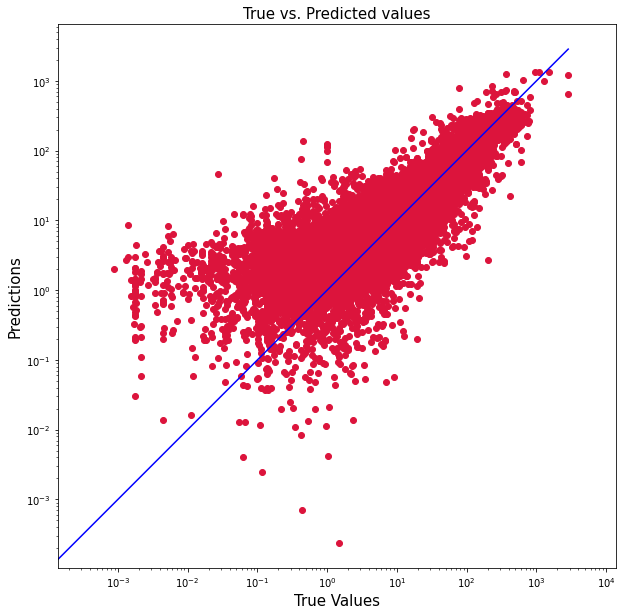

 10%|█         | 20/200 [02:33<21:43,  7.24s/it]

Epoch: 20 Train loss: 483.2796 Val loss: 468.5303 Train score: 21.9836 Val score 21.6469


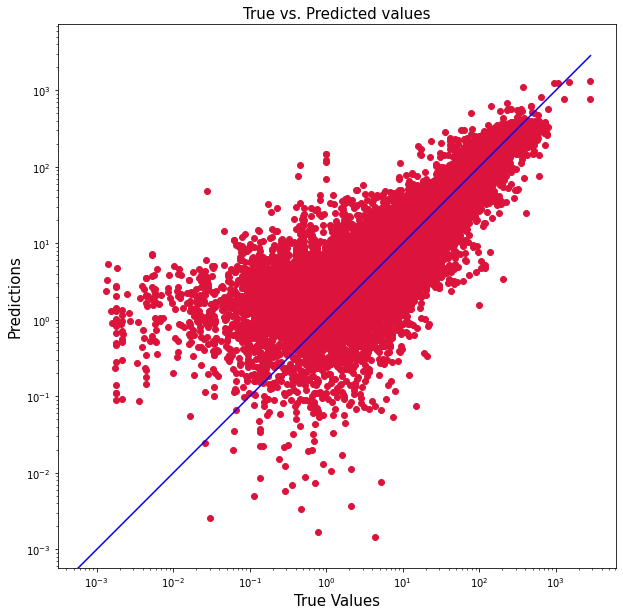

 15%|█▌        | 30/200 [03:44<20:04,  7.09s/it]

Epoch: 30 Train loss: 447.87 Val loss: 445.9211 Train score: 21.163 Val score 21.1182


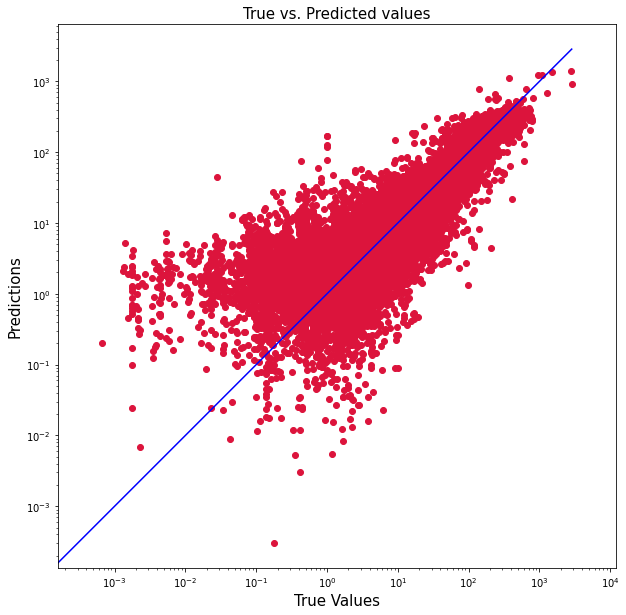

 20%|██        | 40/200 [04:56<19:08,  7.18s/it]

Epoch: 40 Train loss: 420.6607 Val loss: 434.7184 Train score: 20.51 Val score 20.8512


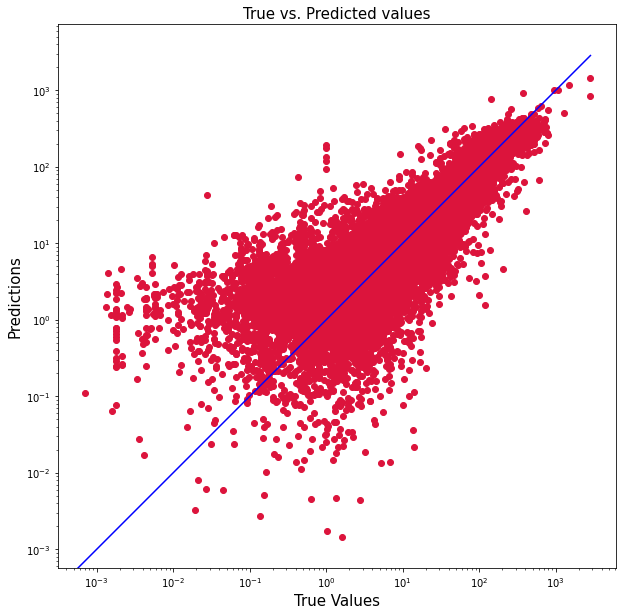

 25%|██▌       | 50/200 [06:17<19:46,  7.91s/it]

Epoch: 50 Train loss: 399.104 Val loss: 422.6863 Train score: 19.9776 Val score 20.5606


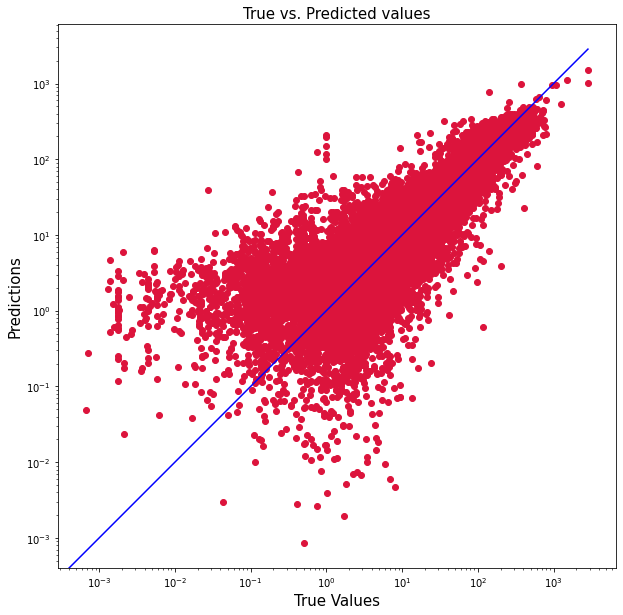

 30%|███       | 60/200 [07:37<18:35,  7.97s/it]

Epoch: 60 Train loss: 390.2237 Val loss: 410.4904 Train score: 19.7541 Val score 20.2618


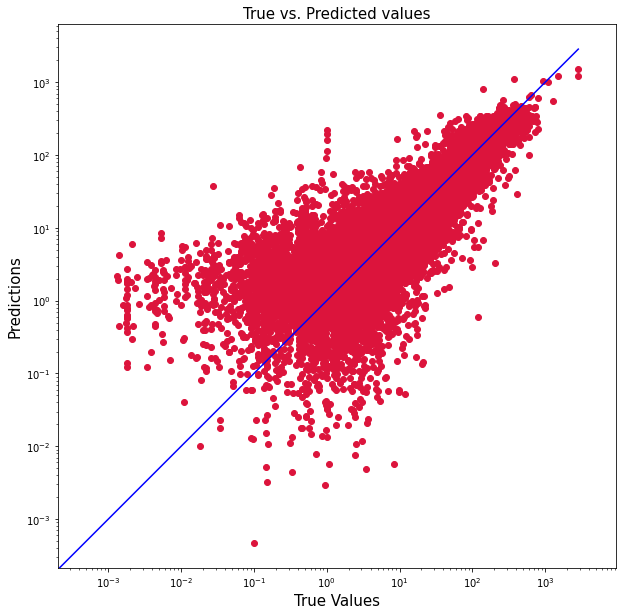

 35%|███▌      | 70/200 [09:04<18:22,  8.48s/it]

Epoch: 70 Train loss: 374.0796 Val loss: 402.1477 Train score: 19.3412 Val score 20.0549


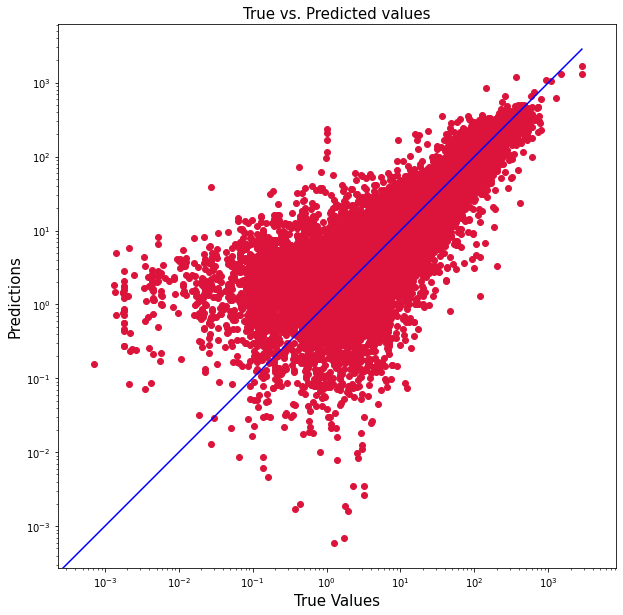

 40%|████      | 80/200 [10:37<19:12,  9.60s/it]

Epoch: 80 Train loss: 359.9595 Val loss: 399.4758 Train score: 18.9726 Val score 19.9881


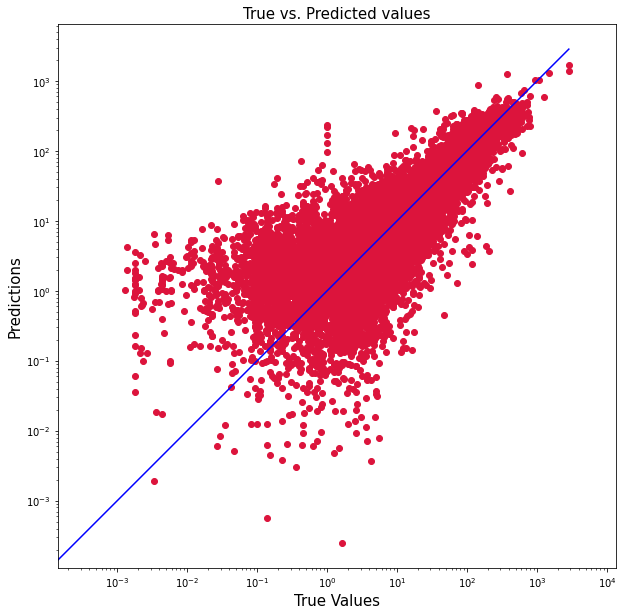

 45%|████▌     | 90/200 [11:59<14:30,  7.91s/it]

Epoch: 90 Train loss: 351.8578 Val loss: 391.4544 Train score: 18.7579 Val score 19.7864


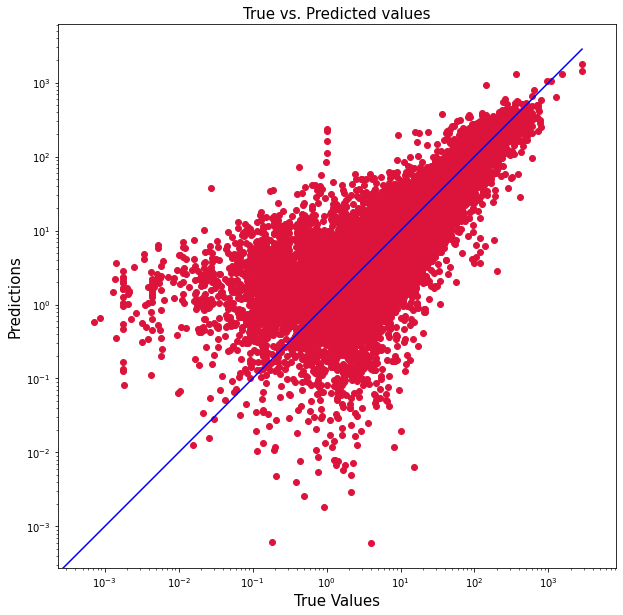

 50%|█████     | 100/200 [13:16<12:39,  7.59s/it]

Epoch: 100 Train loss: 338.7328 Val loss: 391.4705 Train score: 18.4047 Val score 19.7868


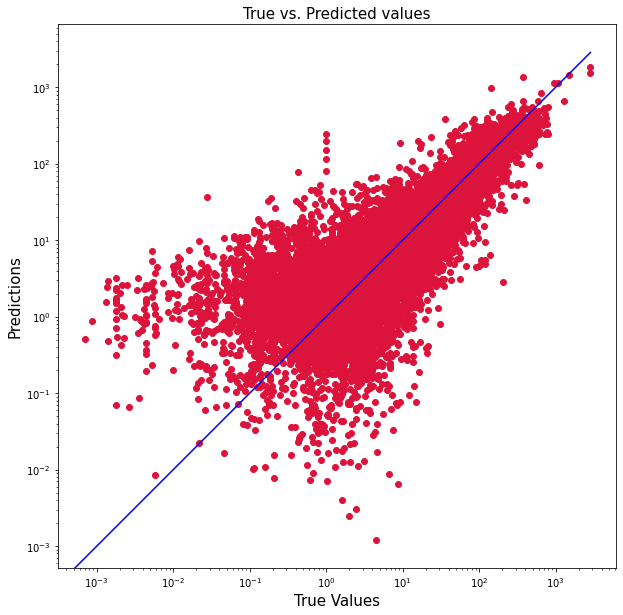

 55%|█████▌    | 110/200 [14:29<10:19,  6.89s/it]

Epoch: 110 Train loss: 333.6302 Val loss: 386.2182 Train score: 18.2656 Val score 19.6536


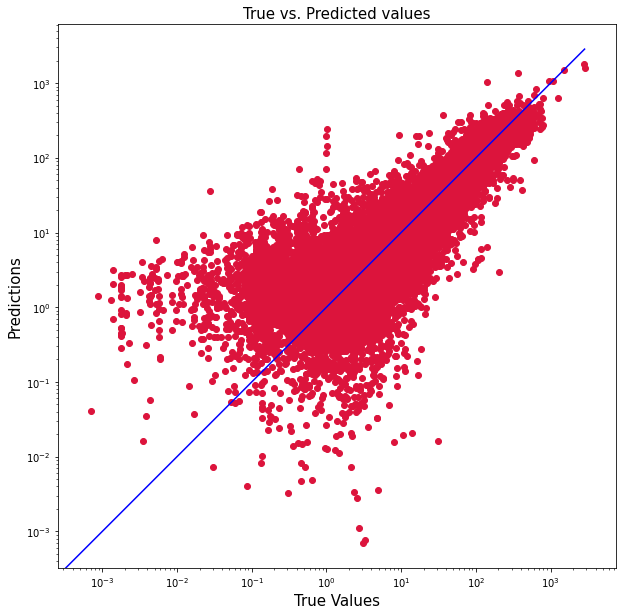

 60%|██████    | 120/200 [15:37<08:40,  6.51s/it]

Epoch: 120 Train loss: 324.8863 Val loss: 387.9388 Train score: 18.0246 Val score 19.6973


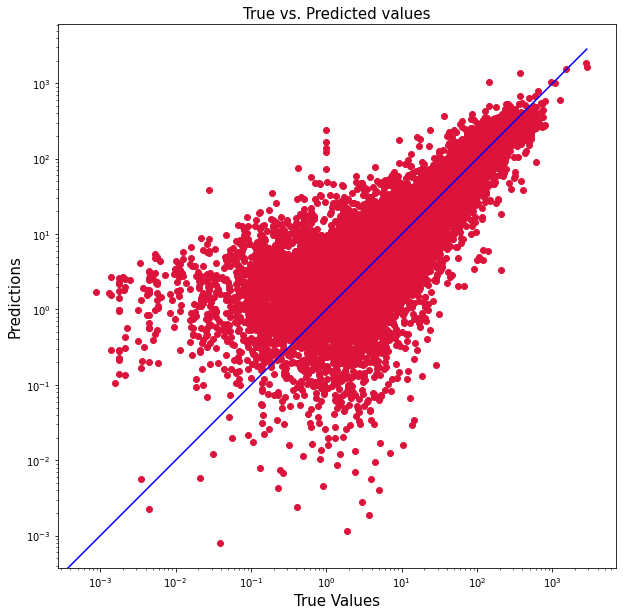

 65%|██████▌   | 130/200 [16:41<07:15,  6.22s/it]

Epoch: 130 Train loss: 318.3898 Val loss: 391.7658 Train score: 17.8435 Val score 19.7943


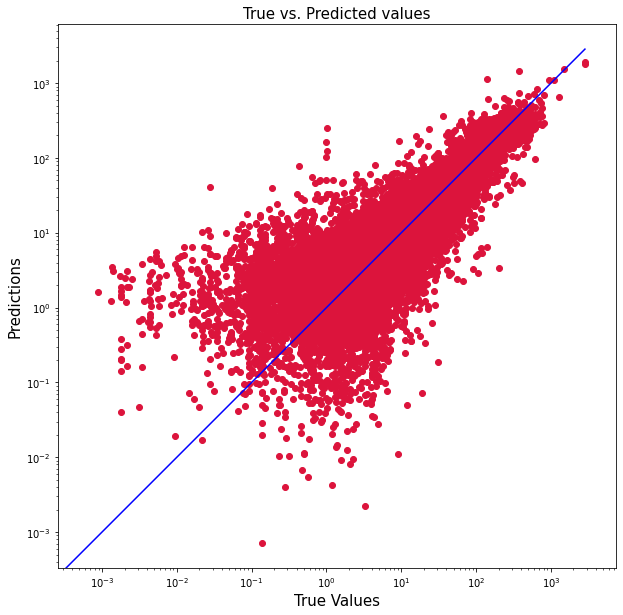

 70%|███████   | 140/200 [17:45<06:20,  6.34s/it]

Epoch: 140 Train loss: 309.368 Val loss: 392.1258 Train score: 17.5889 Val score 19.8034


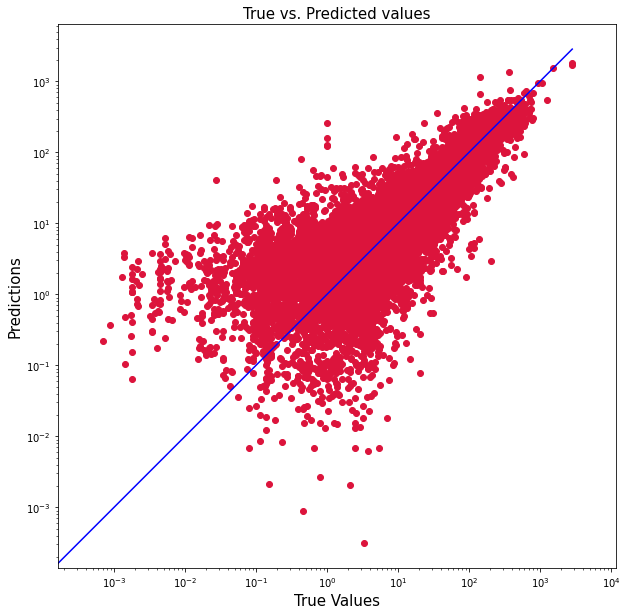

 75%|███████▌  | 150/200 [18:49<05:17,  6.36s/it]

Epoch: 150 Train loss: 305.1376 Val loss: 403.9529 Train score: 17.4682 Val score 20.0999


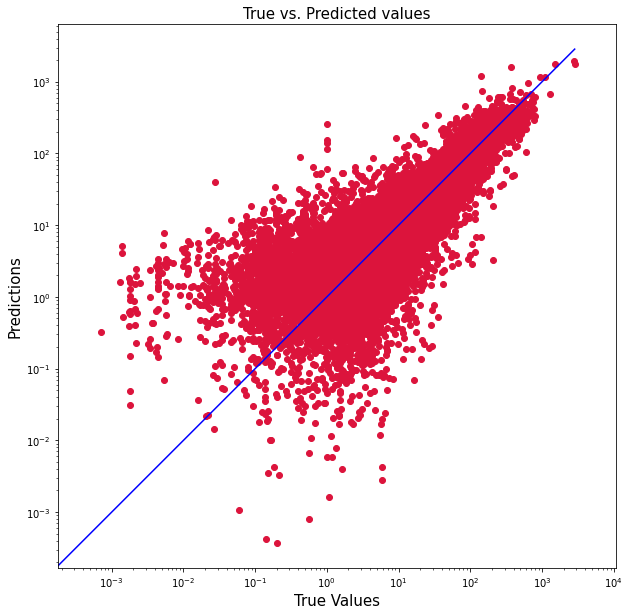

 80%|████████  | 160/200 [19:54<04:11,  6.30s/it]

Epoch: 160 Train loss: 300.7051 Val loss: 400.851 Train score: 17.3409 Val score 20.0225


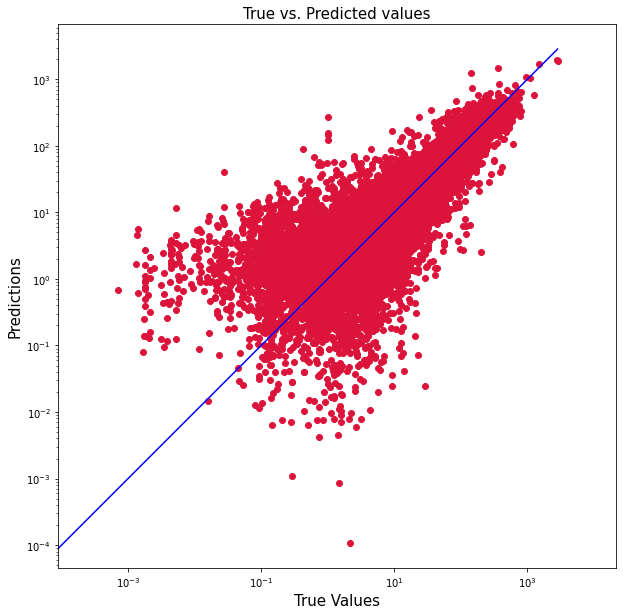

 85%|████████▌ | 170/200 [20:59<03:12,  6.42s/it]

Epoch: 170 Train loss: 288.092 Val loss: 395.7107 Train score: 16.9733 Val score 19.8936


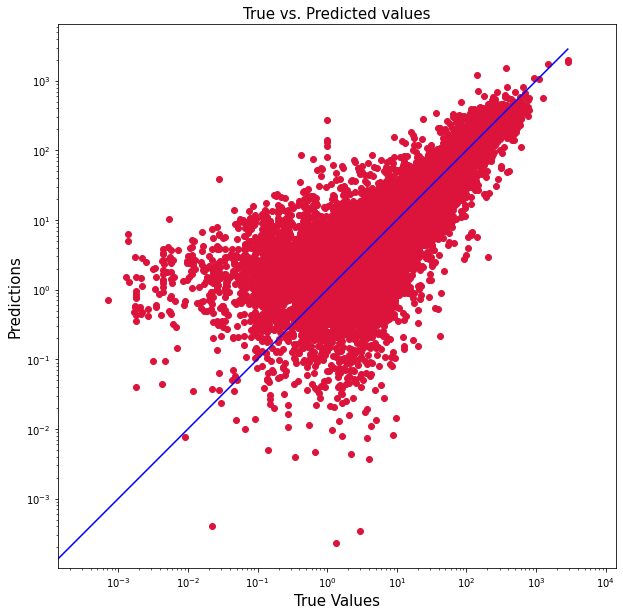

 90%|█████████ | 180/200 [22:05<02:12,  6.64s/it]

Epoch: 180 Train loss: 286.4931 Val loss: 406.1511 Train score: 16.9261 Val score 20.1545


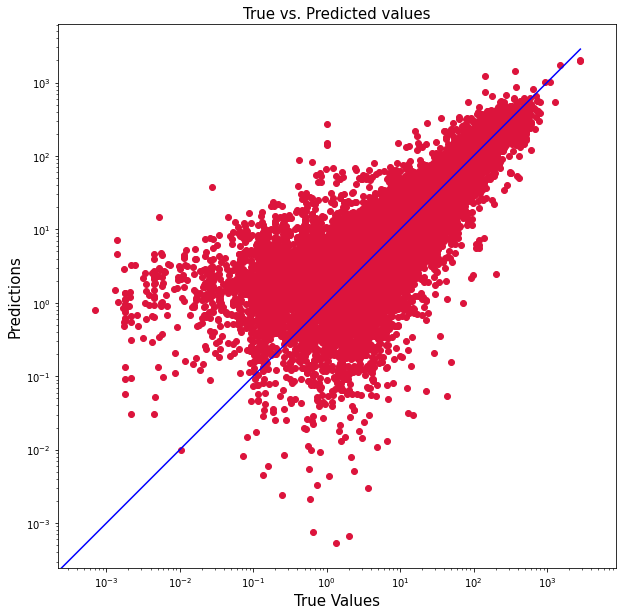

 95%|█████████▌| 190/200 [23:11<01:06,  6.61s/it]

Epoch: 190 Train loss: 280.4158 Val loss: 405.0653 Train score: 16.7456 Val score 20.1275


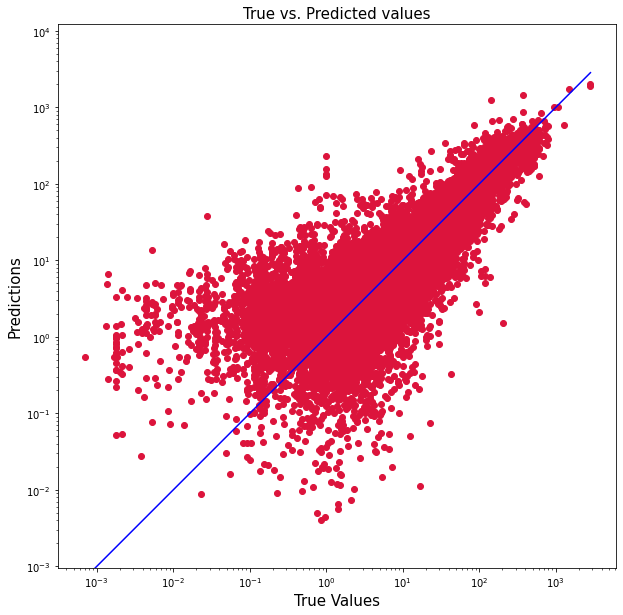

100%|██████████| 200/200 [24:13<00:00,  7.27s/it]


Epoch: 199 Train loss: 272.5608 Val loss: 412.1096 Train score: 16.5094 Val score 20.3019


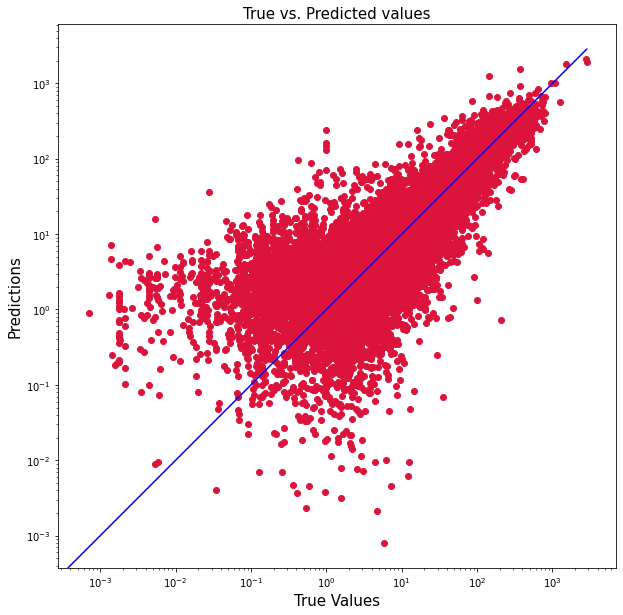

2022-05-09 00:37:31.847882 训练结束...


In [120]:
from datetime import datetime
from tqdm import tqdm
from colorama import Fore, Back

epochs = 200
print(f'{datetime.now()} start training...')
for epoch in tqdm(range(epochs)):
    train_batch_num, train_mean_loss, train_score = train_loop(train_iter,model,loss_fn,optimizer)
    
    val_mean_loss, val_score, y_true, y_pred = test_loop(val_iter,model,loss_fn)

    if epoch%10  == 0:
        print(Fore.CYAN + Back.BLACK, end='')
        tqdm.write(f'Epoch: {epoch} Train loss: {train_mean_loss} Val loss: {val_mean_loss}', end=' ')
        tqdm.write(f'Train score: {train_score} Val score {val_score}')
        plot_true_pred(y_true,y_pred)

print(Fore.CYAN + Back.BLACK, end='')
tqdm.write(f'Epoch: {epoch} Train loss: {train_mean_loss} Val loss: {val_mean_loss}', end=' ')
tqdm.write(f'Train score: {train_score} Val score {val_score}')
plot_true_pred(y_true,y_pred)

print(f'{datetime.now()} training ends...')